# Activate IAF Neuron

## 0. Kick the Baby
If you've ever watched **South Park**, then you probably remember one scene in which Kyle punts his little brother Ike like a football after saying,
>"Kick the baby!"

,to which Ike responds,

>Don't kick the goddamn baby!

![Kick the Baby!](../Figures/KickBaby.jpg)

In this lab, we're also gonna **Kick the Baby**!

>More specifically, *Baby* stands for the **integrate-and-firing(IAF) neuron** and *Kick* stands for **activating with spikes**.

In [8]:
# %matplotlib inline

# System Env
import sys
sys.path.append('..')

# Nest Modules
import nest
import nest.topology as tp

# Help Functions
from CNT.visualize import visualSS, visualVS
from CNT.spikeAnalyzer import spike2bin, spikeCoin

# Common Modules
import numpy as np
import matplotlib.pyplot as plt

# Auto Reloading
%load_ext autoreload
%autoreload 2

## 1. IAF Neuron

$$I(t) = C_m\frac{dV_m(t)}{dt}$$

The equation above is the simple capcitor-resistor model of a naive IAF neuron. It simply **integrates** ions and **fires** when reaching a boundary.  
Our first try would be activating an IAF neuron with constant **current injection**. 
>Now, let's give it a KICK!

<Figure size 432x288 with 0 Axes>

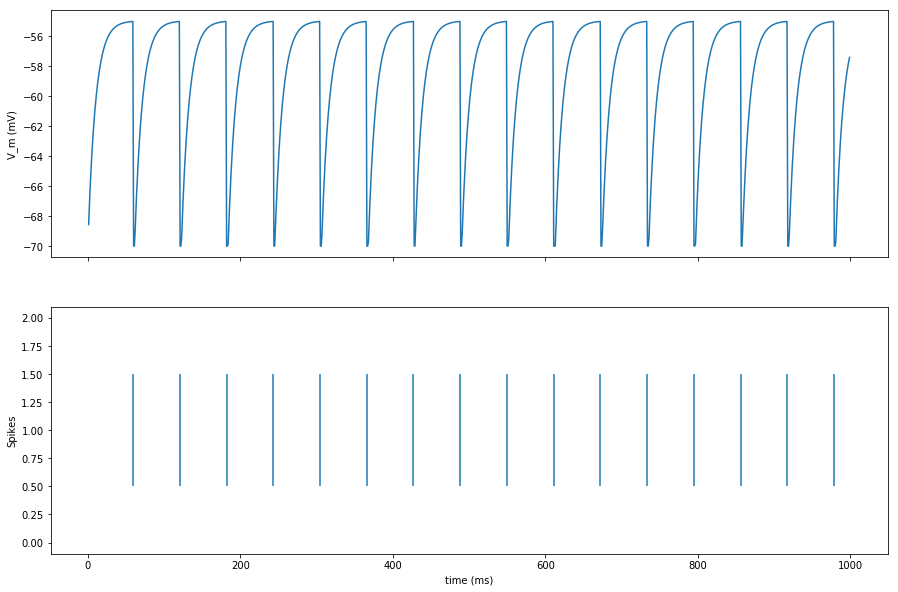

In [2]:
# Simulation setting
dt = 0.1    # Computation step size in ms
T = 1000.0  # Total duration

# Initialize nest env
nest.ResetKernel()
nest.SetKernelStatus({"local_num_threads": 1, "resolution": dt})

# Create a naive iaf neuron
neuron = nest.Create('iaf_psc_alpha')

# Set constant current injection
nest.SetStatus(neuron, "I_e", 376.0)

# Create a voltmeter device
vm = nest.Create('voltmeter')
nest.SetStatus(vm, "withtime", True)

# Create a spike detector device
sd = nest.Create('spike_detector')

# Connect devices to neuron
nest.Connect(vm, neuron)
nest.Connect(neuron, sd)

# Simulate
nest.Simulate(T)

# Visualize soma recording(voltmeter) and spiking activities(spike detector)
visualVS(vm, sd);

So the neuron spikes and resets periodically with constant current injection which we already know. Well, not so interesting. 
>What about we try something else? Something that **makes more sense**?

One thing that you should keep in mind is that when neuroscientists talk about making sense, they probably have the idea of **biological plausibility** in mind. Let's just stick to this meaning as start and take a glimpse of what could happen in real brain.

## 2. Correlation Via Connection

### A Two-layer Network

Now, here's a two-layer network with its topology defined below.

In [3]:
# Initialize nest env
nest.ResetKernel()

N_ex = 100  # size of the population
p_ex = 0.3  # connection probability inside the population
r_ex = 0.4  # neighbourhood size
w_ex = 30.0  # synaptic weights inside the population (pA)
d_ex = 10.0  # synaptic weights fluctuation

N_noise = 100  # size of Poisson group(input pool)
rate_noise = 10.0  # firing rate of Poisson neurons (Hz)
p_noise = 0.9  # connection probability from noise to population
r_noise = 0.5  # neighbourhood size
w_noise = 200.0  # synaptic weights from Poisson to population neurons (pA)
d_noise = 10.0  # synaptic weights fluctuation

# Topoloy
radius = 0.5
# Neuron(output) population
pos = [[np.random.uniform(-radius, radius),np.random.uniform(-radius, radius),np.random.uniform(-radius, radius)] for i in range(N_ex)]
# pos = [[np.random.uniform(-radius, radius),np.random.uniform(-radius, radius)] for i in range(N_ex)]
pop_layer = {"positions": pos,
            "elements" : "iaf_psc_alpha"}
population = tp.CreateLayer(pop_layer)

# Noise(input) population
pos = [[np.random.uniform(-radius, radius),np.random.uniform(-radius, radius),np.random.uniform(-radius, radius)] for j in range(N_noise)]
nest.CopyModel("poisson_generator", 'poisson_input', params={'rate': rate_noise})
noise_layer = { "positions": pos,
                "elements" : 'poisson_input'} # the element at each (x,y) coordinate in the grid
noise = tp.CreateLayer(noise_layer)

# Recurrent connection
recondict = {'connection_type': 'divergent', 
             'mask': {'spherical': {'radius': r_ex}},
             'kernel': p_ex,
             'weights': {'uniform': {'min': w_ex-d_ex, 'max': w_ex+d_ex}},
             'allow_autapses': False}
tp.ConnectLayers(population, population, recondict)

# Input connection
incondict = {'connection_type': 'divergent', 
             'mask': {'spherical': {'radius': r_noise}}, 
             'kernel': p_noise,
             'weights': {'uniform': {'min': w_noise-d_noise, 'max': w_noise+d_noise}},
             'allow_multapses': False,
             'allow_autapses': False}
tp.ConnectLayers(noise, population, incondict)

# Spike detectors
spike_det = nest.Create("spike_detector")
pop_det = nest.Create('spike_detector', N_ex)
noise_det = nest.Create('spike_detector', N_noise)

# Connect detectors
nest.Connect(nest.GetNodes(population)[0], spike_det)
nest.Connect(nest.GetNodes(population)[0], pop_det, 'one_to_one')
nest.Connect(nest.GetNodes(noise)[0], noise_det, 'one_to_one')

/Users/michaelh/.nest/lib/python3.7/site-packages/nest/lib/hl_api_helper.py:91: UserWarning: 
GetNodes is deprecated and will be removed in NEST 3.0. Use GIDCollection instead.
  warnings.warn('\n' + text)   # add LF so text starts on new line


There are two ensembles of neurons distributed in 3D space. We'll call those two ensembles the *input layer* and the *output layer*.

#### Output Layer

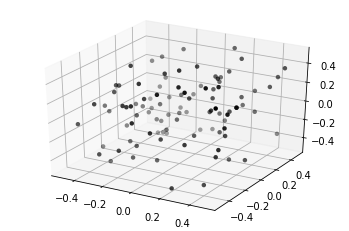

In [4]:
tp.PlotLayer(population, nodesize=20, nodecolor='k');

#### Input Layer

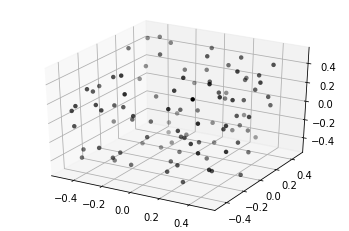

In [5]:
tp.PlotLayer(noise, nodesize=20, nodecolor='k');

#### Recurent Connection

Neurons in the output layer are **inter-connected IAF neurons** receiving stimulus from the input layer. Each neuron is connected to its neighbours with certain probability. As shown below, a neuron in the center(large red dot) connects to several neighbouring neurons(small red dots).

/Users/michaelh/.nest/lib/python3.7/site-packages/nest/lib/hl_api_helper.py:91: UserWarning: 
GetChilden is deprecated and will be removed in NEST 3.0. Use GIDCollection instead.
  warnings.warn('\n' + text)   # add LF so text starts on new line


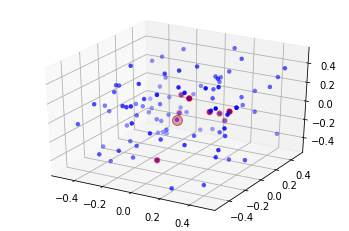

In [6]:
# Visualize
layer = population
condict = recondict

# layer nodes
fig = tp.PlotLayer(layer, nodesize=20)

# kernel
ctr = tp.FindCenterElement(layer)
tp.PlotTargets(ctr, layer, fig=fig,
               mask=condict['mask'],
               kernel=condict['kernel'], kernel_color='green',
               src_size=100, tgt_color='red', tgt_size=40);

#### Divergent Connection

Each neuron in the input layer generates a **poisson spike train**. Neurons in the input layer connect to close neighbours in the output layer if we overlap the space of these two layers. As shown below, a neuron in the center(large red dot) connects to several neighbouring neurons(small red dots) in overlapped space.

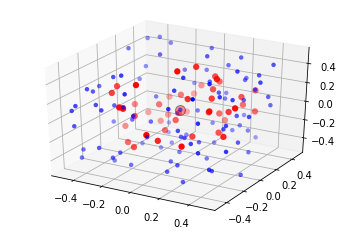

In [7]:
# Visualize
layer = noise
condict = incondict

# layer nodes
fig = tp.PlotLayer(layer, nodesize=20)

# kernel
ctr = tp.FindCenterElement(layer)
tp.PlotTargets(ctr, population, fig=fig,
               mask=condict['mask'],
               kernel=condict['kernel'], kernel_color='green',
               src_size=100, tgt_color='red', tgt_size=40);

>Cool, let's kick it now!

<Figure size 432x288 with 0 Axes>

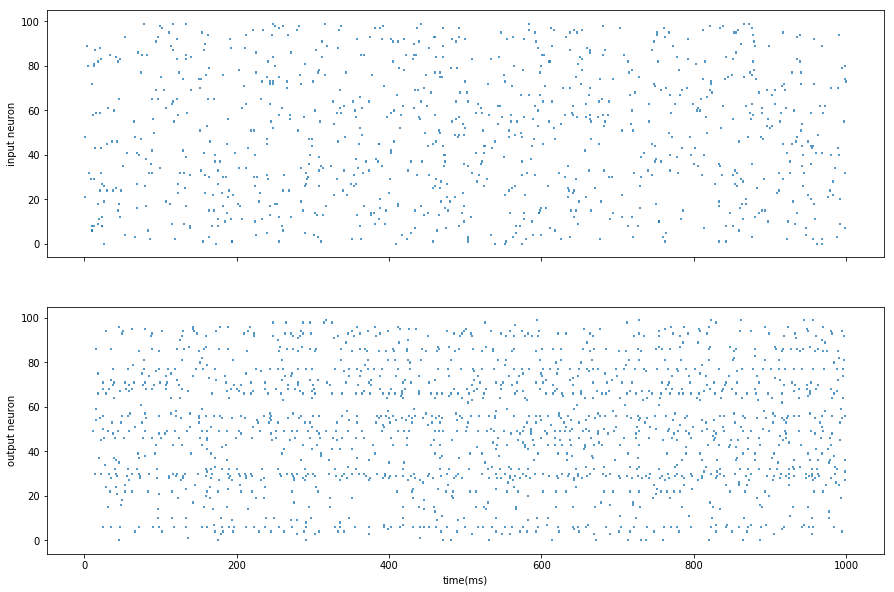

In [8]:
# Simulation setting
dt = 0.1    # Computation step size in ms
T = 1000.0  # Total duration

# Simulate
nest.ResetNetwork()
nest.Simulate(T)

# Visualize spiking activities of neuron populations
visualSS(noise_det, pop_det);

### Coincidence of Spikes

Intuitively, it could be seen that output spikes have a clearer pattern. Let's count the **coincidence of spikes** between different output neurons shown above.

Text(0, 0.5, 'Neuron Idx')

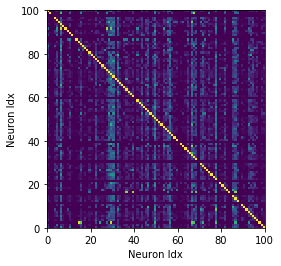

In [9]:
# Recording
eventS = nest.GetStatus(pop_det, 'events')
spikes = [event['times'] for event in eventS]

# Binning
vS = np.zeros([N_ex, int(T/dt)])
kernel = np.ones(int(5/dt))
for i,spike in enumerate(spikes):
    vS[i] = spike2bin(signal=spike, template=vS[i], kernel=kernel, dt=dt)

# Counting coincidence
coM,_ = spikeCoin(spikeMat=vS, type=1)
plt.imshow(coM, extent=[0,N_ex,0,N_ex])
plt.xlabel('Neuron Idx')
plt.ylabel('Neuron Idx')

As shown above, some pairs of neurons have strong correlations. Correlation arises in this simple two-layer network. However,
>**What is the underlying mechanism?**

In this simple case, the correlation of output activities arise from the sharing of inputs as a natural result. Next, let's look even closer at a single neuron and ask this question:
>**If we consider a neuron as an input-output device, how is input correlation projected to output correlation?**

## 3. Correlation Via Single Neuron

### Probablistic Copy
We are gonna generate spike trains with arbitrary correlations by simply using probabilistic copy. It means, just as the words, to copy spikes from a common spike train with certain probability.

![Correlation Single Neuron](../Figures/Correlation.png)

As shown in the figure above, a *mother spike* train is copied to several *pool spike* trains with probability $b$. Then each *pool spike* train is copied to a pool of *input neurons* with probability $w$. With input prepared as such, each pair of pools has certain *pool correlation* and each pair of neurons has certain *individual correlation*.

### Activating Neuron
We activate the same target neuron with each pool of input neurons and record the activities of the target neuron shown as the spiking events on the right of above figure. 

>Let's Kick the Neuron!

In [10]:
# Simulation setting
dt = 0.1    # Computation step size in ms
T = 1000.0  # Total duration

# Model setting
N_trial = 2
N_syn = 25
N_bw = 10
nu = 5.0
seed = 0
weight = 20.0

# Save recordings
inEvents = []
outEvents = []

# Between pool copy probability
bps = np.linspace(0.1, 1.0, N_bw)
for i,bp in enumerate(bps):
    # Within pool copy probability
    wps = np.linspace(0.1, 1.0, N_bw)
    for j,wp in enumerate(wps):
        # Mother spike frequency
        f = nu/bp/wp
        
        # Initialize nest env
        nest.ResetKernel()
        nest.SetKernelStatus({'local_num_threads': 1, 'resolution': dt,
                      'overwrite_files': True, 'grng_seed': seed})

        # Multiple Interaction Process (MIP) generator
        mg = nest.Create('mip_generator')
        nest.SetStatus(mg, {'rate': f, 'p_copy': bp})
        
        # Temporary variables
        sgS = []
        pnS = []
        inS = []
        tgS = []
        outS = []
        vmS = []
        for _ in range(N_trial):
            # Pool spike trains
            sgS.append(nest.Create('spike_dilutor', N_syn))
            nest.SetStatus(sgS[-1], {'p_copy': wp})
            nest.Connect(mg, sgS[-1])

            # Input neurons
            pnS.append(nest.Create('parrot_neuron', N_syn))
            inS.append(nest.Create('spike_detector', N_syn))
            nest.Connect(sgS[-1], pnS[-1])
            nest.Connect(pnS[-1], inS[-1], 'one_to_one')

            # Output neuron
            tgS.append(nest.Create('iaf_psc_alpha'))
            outS.append(nest.Create('spike_detector'))
            vmS.append(nest.Create('voltmeter'))
            nest.SetStatus(vmS[-1], "withtime", True)

            # Connect devices and inputs
            nest.Connect(pnS[-1], tgS[-1], syn_spec={"weight": weight})
            nest.Connect(tgS[-1], outS[-1], 'one_to_one')
            nest.Connect(vmS[-1], tgS[-1])

        # Simulate
        nest.Simulate(T)
        
        # Save experiment of one (b,w) pair
        inEvent = [nest.GetStatus(inN, 'events') for inN in inS]
        outEvent = [nest.GetStatus(outN, 'events') for outN in outS]
        inEvents.append(inEvent)
        outEvents.append(outEvent)
        
# Extract spikes
inSpikes = []
outSpikes = []
for i in range(N_bw):
    for j in range(N_bw):
        idx = i*N_bw + j
        inSpike = []
        outSpike = []
        for k in range(N_trial):
            inSpike.append([inEvent['times'] for inEvent in inEvents[idx][k]])
            outSpike.append(outEvents[idx][k][0]['times'])
        inSpikes.append(inSpike)
        outSpikes.append(outSpike)
        
# Binning spikes
binOuts = []
kernel = np.ones(int(5/dt))
for i in range(N_bw):
    for j in range(N_bw):
        idx = i*N_bw + j
        binOut = []
        for k in range(N_trial):
            binOut.append(spike2bin(outSpikes[idx][k], np.zeros(int(T/dt)), kernel, dt))
        binOuts.append(np.array(binOut))

#### Absolute Coincidence

The **absolute coincidence** of the output activities has peak value at certain $\{b,w\}$ region. The reason is quite simple: when input correlation is too low, there are not enough spikes arrived at the same time thus cannot activate the neuron; when the input correlation is too high, there are abundant spikes arrived at the same time thus the number of possible activation is reduced. In one word, the inputs are well **exploited** with certain input correlation.

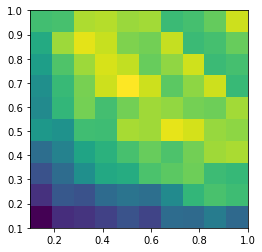

In [11]:
# Count coincidence
coM = np.zeros([N_bw, N_bw])
for i in range(N_bw):
    for j in range(N_bw):
        idx = i*N_bw + j
        coV, coM[i][j]  = spikeCoin(binOuts[idx])
    
# Visualize
plt.figure()
plt.imshow(coM, extent=[0.1,1,0.1,1], origin='lower')

#### Normalized Coincidence

The **absolute coincidence** can be normalized with the **energy** as $c_{norm}(i,j) = \frac{coin(s_i, s_j)}{coin(s_i,s_i)}$, where the function $coin$ calculates the absolute coincidence of two sequences $s_i,s_j$. The normalized coincidence keep increasing as the input correlation or $\{b,w\}$ increases.

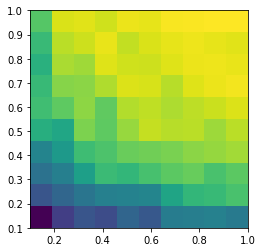

In [12]:
# Count coincidence
coM = np.zeros([N_bw, N_bw])
for i in range(N_bw):
    for j in range(N_bw):
        idx = i*N_bw + j
        coV, coM[i][j]  = spikeCoin(binOuts[idx], type=1)
    
# Visualize
plt.figure()
plt.imshow(coM, extent=[0.1,1,0.1,1], origin='lower')

## 4. Beyond Point Neuron

The neuron we've been dealing with is a point neuron meaning we consider all the magic happens in the **soma** of the neuron. However, the real situation is much more interesting! One additional factor requires consideration is **time delay**. It means the spike trains from different input neurons reach the target neuron with different time delays due to **transportation time**. So when dealing with more realistic models, correlation is analyzed in **time-dependent context**.